In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio, calculate_test_statistic
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [31]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"
plot_data_dir = "plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1
n_folds = 5

In [32]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [33]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)
print(SR_left, SR_right)


data_prefix = f"upsilon_{train_data_id}"
print(data_prefix)

5.0 16.0
9.0 10.6
upsilon_OS


# Load in the original data

In [34]:
# # load in the data corresponding to the train id
# # we actually want the "test band" here -- train is just for flow
# with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
#     test_data_dict = pickle.load(infile)

# with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
#     configs = infile.readlines()[0].decode("utf-8")
    
#     feature_set = [x.strip() for x in configs.split("'")][1::2]

# print(f"Feature Set: {feature_set}")

## Load in the BDT results

In [35]:

print(f"Loading data from {flow_training_dir}")
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Loading data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8/
Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [36]:
# if train_samesign = False, this loads in the OS test data
# test 


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    with open(f"{pickle_save_dir}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
        loc_dict = pickle.load(ifile)
    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = num_pseudoexperiments

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True
True
True
True


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Plot histograms for a small number of FPR thresholds

In [37]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]


# Save the FPR thresholds
with open(f"{plot_data_dir}{data_prefix}_fpr_thresholds", "wb") as ofile:
    pickle.dump(fpr_thresholds, ofile)

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

In [38]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    # ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    # ax.axvline(11.020, color="black", linestyle="--", alpha=0.15)
    # ax.text(11.020 * 0.995, 1e4, r"$\Upsilon(5S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)

In [39]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True,):
    

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_type"] = fit_type
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    if fit_type == "cubic": degree = 3
    elif fit_type == "quintic": degree = 5
    elif fit_type == "septic": degree = 7

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    # Get a list of all possible cuts for the feature


    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    

        # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        

                    # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
    
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt)

        # test_statistic(masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov, ONE_SIDED = True, verbose = False)

        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        total_events = len(filtered_masses)



        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)



    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.01, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data
    


<>:141: SyntaxWarning: invalid escape sequence '\m'
<>:141: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_725053/3679944711.py:141: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


Saved Data to plot_data/upsilon_OS_histogram_data_quintic_12.pickle


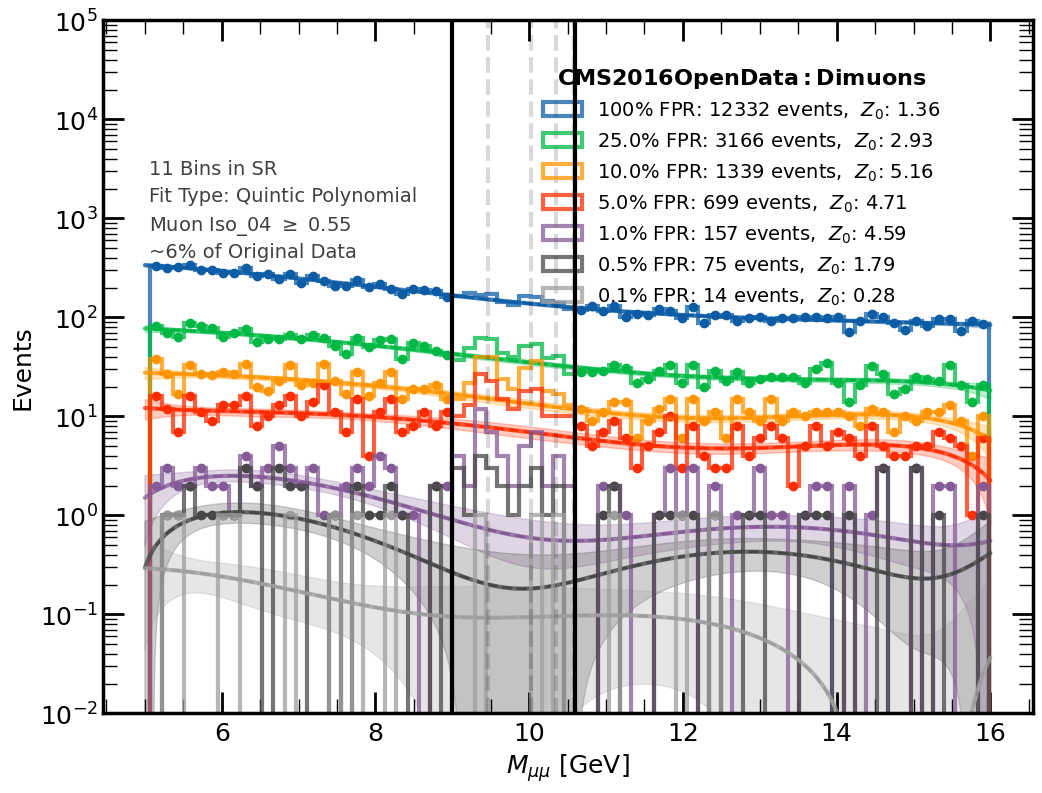

In [40]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
pseudo_e_to_plot = 0
save_data = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"upsilon OS\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

print("Saved Data to " + f"{plot_data_dir}{data_prefix}_histogram_data_{fit_type}_{num_bins_SR}.pickle")

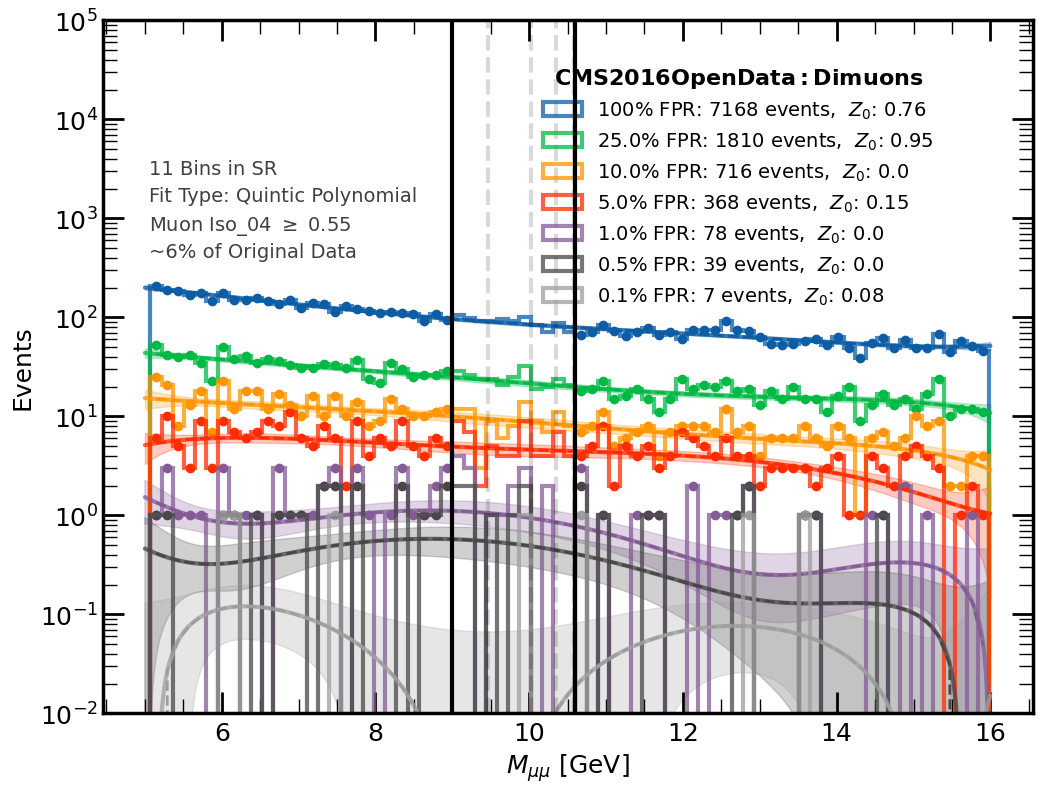

In [41]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"upsilon SS",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


In [42]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

In [43]:
# """
# PLOT HISTOGRAM ON FLOW SAMPLES
# """
# plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Feature Plots

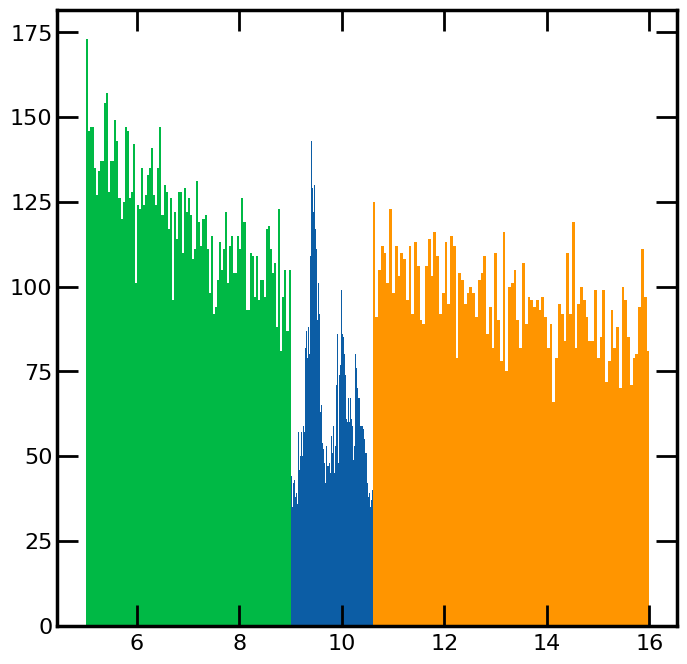

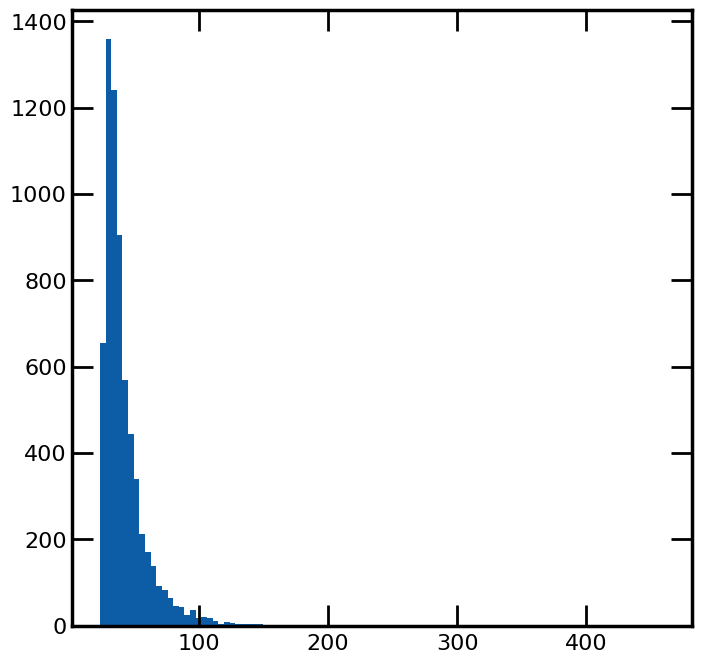

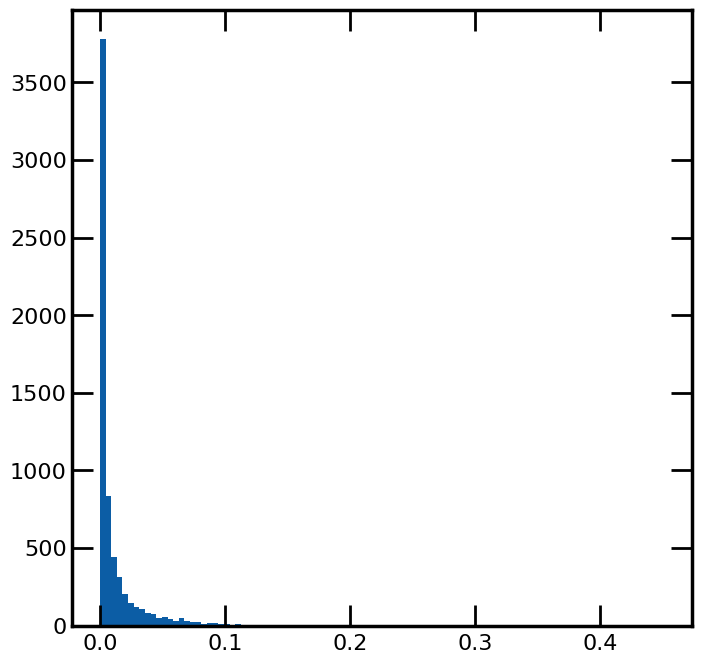

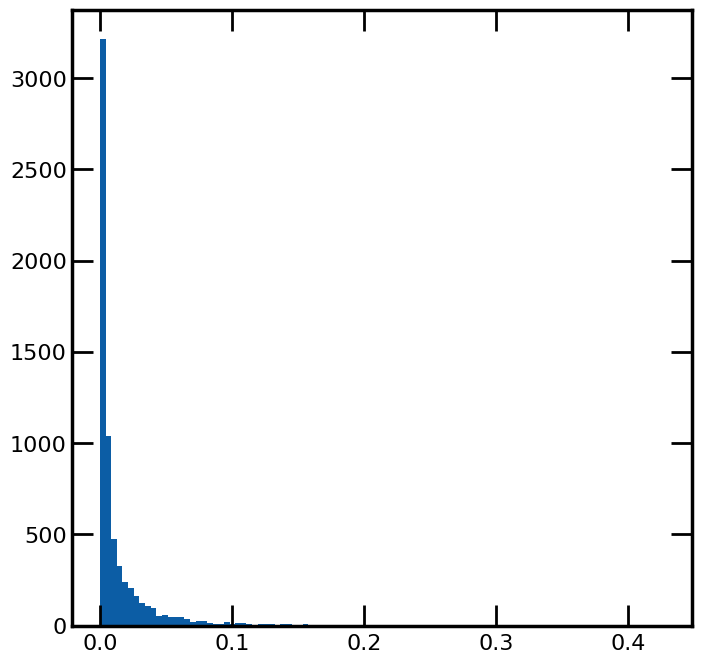

In [ ]:
import pickle
import matplotlib.pyplot as plt

path_to_OS_data = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_12_03/processed_data/data_noIsoCut_noPreproc_OS_test_band_data"
with open(path_to_OS_data, "rb") as infile:
    data = pickle.load(infile)
    SR_data_OS = data["SR"]['skimmed_data_2016H_30555_nojet']
    SBL_data_OS = data["SBL"]['skimmed_data_2016H_30555_nojet']
    SBH_data_OS = data["SBH"]['skimmed_data_2016H_30555_nojet']




plt.figure()
plt.hist(SR_data_OS["dimu_mass"], bins = 100)
plt.hist(SBL_data_OS["dimu_mass"], bins = 100)
plt.hist(SBH_data_OS["dimu_mass"], bins = 100)
plt.show()

plt.figure()
plt.hist(SR_data_OS["dimu_pt"], bins = 100)
plt.show()

plt.figure()
plt.hist(SR_data_OS["mu0_ip3d"], bins = 100)
plt.show()

plt.figure()
plt.hist(SR_data_OS["mu1_ip3d"], bins = 100)
plt.show()

# Save the SR data
with open(f"{plot_data_dir}{data_prefix}_SR_data_OS.pickle", "wb") as ofile:
    pickle.dump(SR_data_OS, ofile)



In [46]:
from helpers.data_transforms import scaled_to_physical_transform

def plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):



    pre_isoation_cut_data = SR_data_OS

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["features"] = []

    n_features = len(feature_set) - 1
    nbins = 40

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-6, 0, nbins),
        "mu1_ip3d": np.logspace(-6, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }

    
    
    fig, ax = plt.subplots(1, n_features, figsize = (5*n_features, 5))


    for i_feat in range(n_features):

        ax[i_feat].hist(pre_isoation_cut_data[feature_set[i_feat]], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = "black",label = "Pre-Isolation Cut", alpha = 0.75)


    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_features = {i:[] for i in range(n_features)}

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
                
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
                 
            loc_in_SR_indices =  (loc_true_masses >= SR_left) & (loc_true_masses <= SR_right) 
            loc_score_indices = (loc_scores >= score_cutoffs_by_fold[i_fold][threshold])
            
            loc_pass_indices = loc_in_SR_indices.reshape(-1,) & loc_score_indices.reshape(-1,)
            
            for i_feat in range(n_features):
                # undo the scaling
                selected_features = scaled_to_physical_transform(data_dict_by_fold[i_fold][:,i_feat], preprocessing_info[feature_set[i_feat]], cushion = 0.02)
                filtered_features[i_feat].append(selected_features[loc_pass_indices])
                
        for i_feat in range(n_features):
            filtered_features[i_feat] = np.concatenate(filtered_features[i_feat])   

        save_data["features"].append(filtered_features)

        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"% FPR"
            


            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
            ax[i_feat].set_yscale("log")
            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(1e-1, 5*1e3)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])


           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (1.05, 0.4), fontsize = 16)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)
    return save_data

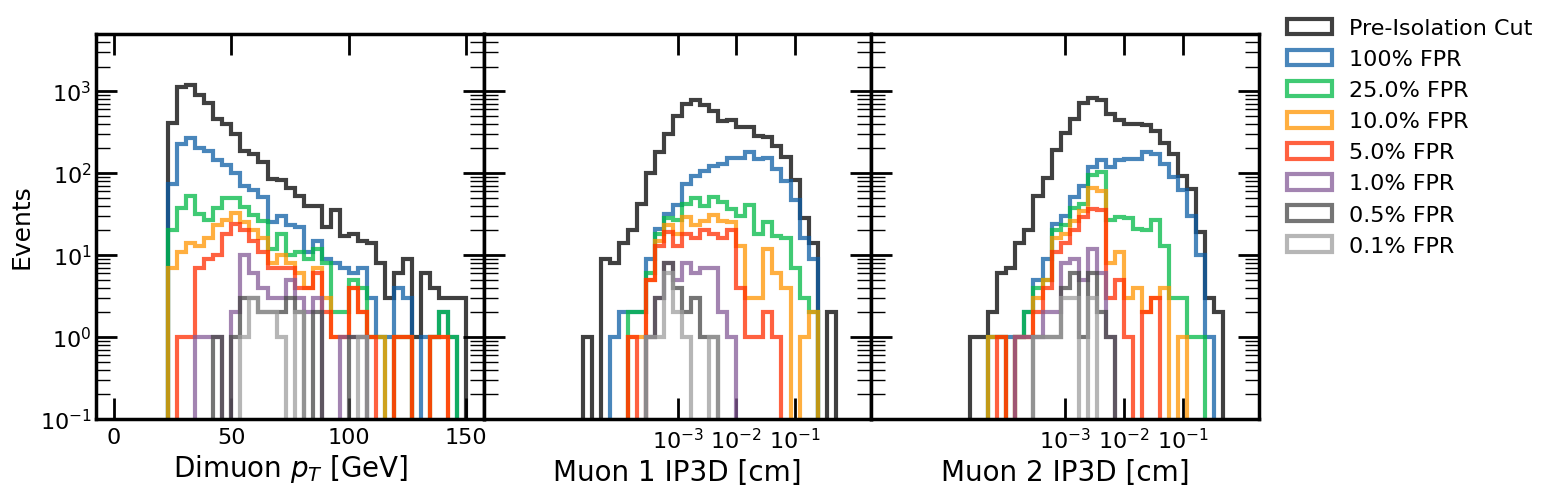

In [ ]:
save_data = plot_features(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, SR_left, SR_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_feature_data_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

In [18]:
def plot_features(save_data, colors, alphas):


    fpr_thresholds = save_data["fpr_thresholds"]
    filtered_features_all = save_data["features"]


    n_features = len(feature_set) 
    nbins = 50

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-4, 0, nbins),
        "mu1_ip3d": np.logspace(-4, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }

    
    
    fig, ax = newplot("column", width = 9, height = 3, subplot_array=(1, n_features))
    # fig, ax = plt.subplots(1, n_features, figsize = (9, 3))
    
    for t, threshold in enumerate(fpr_thresholds):

        filtered_features = filtered_features_all[t]
        
   
        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"\% FPR"


            

            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 2, histtype = "step", color = colors[t],label = label_string, alpha = alphas[t])
            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 2, histtype = "stepfilled", color = colors[t], alpha = 0.03)
            ax[i_feat].set_yscale("log")

            if i_feat == 0:
                ax[i_feat].set_xlim(10, 150)
                ax[i_feat].set_xticks([0, 50, 100, 150])

            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(5e-1, 1e3)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])

    starting_x = 0.075
    starting_y = 0.955
    delta_y = 0.05
    text_alpha = 0.75

    line0 = r"Opposite Sign: $\mu^+\mu^-$"
    line1 = f"Bin width = {bin_percent[num_bins_SR]}\%"
    line2 = f"Fit Type: {fit_type.capitalize()}"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"16.4fb$^{-1}$, $\sqrt{s} = 13$ TeV"

    if line0 is not None:
        ax[1].text(starting_x, starting_y - (0) * delta_y, r"$\texttt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVt}$", transform=ax[1].transAxes, fontsize=7, verticalalignment='top', alpha = text_alpha, zorder = 10)
        ax[1].text(starting_x, starting_y - (1) * delta_y, line0, transform=ax[1].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    ax[2].text(starting_x, starting_y - 0 * delta_y, line1, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 1 * delta_y, line2, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 2 * delta_y, line3, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 3 * delta_y, line4, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$"
    plt.title(title, fontsize = 10, loc = "right")
           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    ax[0].legend(loc = "upper right", fontsize = 8)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)



    return save_data2

<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:64: SyntaxWarning: invalid escape sequence '\%'
<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:64: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_725053/3146857549.py:34: SyntaxWarning: invalid escape sequence '\%'
  label_string = str(round(100*threshold, 2))+"\% FPR"
/tmp/ipykernel_725053/3146857549.py:64: SyntaxWarning: invalid escape sequence '\%'
  line1 = f"Bin width = {bin_percent[num_bins_SR]}\%"


# Classical Studies

In [19]:
# from helpers.plotting import feature_bins


# def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False):
#     """
#     Plot the feature cuts for the given data, scores, and score cutoffs.

#     Parameters
#     ----------
#     feature : str
#         The feature to plot the cuts for.
#     fpr_thresholds : list
#         The list of FPR thresholds to plot.
#     test_data_dict : dict
#         The dictionary of test data.
#     mass_scalar : sklearn.preprocessing.StandardScaler
#         The mass scaler.
#     fit_type : str
#         The type of fit to use for the background.
#     title : str
#         The title of the plot.
#     SB_left : float
#         The left side of the sideband.
#     SR_left : float
#         The left side of the signal region.
#     SR_right : float
#         The right side of the signal region.
#     SB_right : float
#         The right side of the sideband.
#     """

        
#     save_data = {}
#     save_data["fpr_thresholds"] = fpr_thresholds
#     save_data["fit_type"] = fit_type
#     save_data["num_bins_SR"] = num_bins_SR
#     save_data["popts"] = []
#     save_data["pcovs"] = []
#     save_data["significances"] = []
#     save_data["filtered_masses"] = []
#     save_data["y_vals"] = []

#     # Unpack the data dictionary to extract the feature of interest 
#     feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
#     feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
#     feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

#     if flip:
#         feature_SBL = -feature_SBL
#         feature_SR = -feature_SR
#         feature_SBH = -feature_SBH

#     # Unpack the data dictionary to extract the dimuon mass spectrum
#     mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
#     mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
#     mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

#     # Get a list of all possible cuts for the feature
#     feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

#     # For each cut, calculate the number of signal and background events in the SR
#     num_in_SBL = []
#     num_in_SR = []
#     num_in_SBH = []
#     FPR = []
#     for cut in feature_cut_points:
#         num_in_SBL.append(np.sum(feature_SBL >= cut))
#         num_in_SR.append(np.sum(feature_SR >= cut))
#         num_in_SBH.append(np.sum(feature_SBH >= cut))


#         # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
#         # FPR is the combination of SBH and SBL
#         FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
#     # Set up fit types
#     if fit_type == "cubic": fit_function = bkg_fit_cubic
#     elif fit_type == "quintic": fit_function = bkg_fit_quintic
#     elif fit_type == "septic": fit_function = bkg_fit_septic

#     plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

#     fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


#     # fig, ax = newplot("full", aspect_ratio = 1.5)
#     fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
#     for t, threshold in enumerate(fpr_thresholds):


#         # Use interpolation to find the cut point that gives the desired FPR
#         best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

#         # Make the cuts to both the feature and the mass
#         feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
#         feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
#         feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

#         mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
#         mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
#         mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

#         # Concatenate to get the full mass spectrum
#         filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

#         # get the fit function to SB background
#         # popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv_CLASSICAL(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_SR, plot_bins_right, plot_centers_all)
#         popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
#         #print("chi2/dof:", chi2/n_dof)
        
#         # plot the fit function
#         plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

#         # calculate significance of bump
#                 # calculate significance of bump
#         if ONE_SIDED:
#             num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, ONE_SIDED)
#             q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)


#             y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
#             B_error = np.sqrt(np.sum(y_err**2))
#             S_over_B = num_S_expected_in_SR/num_B_expected_in_SR

            

#         label_string = str(round(100*threshold, 2))+"% FPR: "+str(len(feature_SBL_cut)+len(feature_SR_cut)+len(feature_SBH_cut))+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))


#         hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
#         # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
#         plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


#         save_data["popts"].append(popt)
#         save_data["pcovs"].append(pcov)
#         save_data["significances"].append(np.sqrt(q0))
#         save_data["filtered_masses"].append(filtered_masses)
#         save_data["y_vals"].append(y_vals)

#     line1 = f"{num_bins_SR -1 } Bins in SR"
#     line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
#     line3 = r"Muon Iso_04 $\geq$ 0.55"
#     line4 = r"~6% of Original Data"

#     starting_x = 0.475
#     starting_y = 0.45
#     delta_y = 0.04
#     text_alpha = 0.75
#     ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
#     ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


#     legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$: "+feature
#     plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


#     plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
#     plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

#     plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
#     plt.ylabel("Events", fontsize = 18)

#     # plt.yscale("log")
#     plt.ylim(0.5, 1e3)

#     # Add more x ticks (major and minor)
#     plt.xticks(fontsize = 18)
#     plt.yticks(fontsize = 18)
#     plt.minorticks_on()
#     plt.tick_params(axis='x', which='minor', bottom=True)
#     plt.tick_params(axis='y', which='minor', left=True)

#     plot_upsilon_resonances(ax)

#     return save_data


In [20]:
# flip_features = [False, True, True]
# for feature in feature_set[:-1]:
#     print(feature)
#     save_data =  plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, fit_type, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])
#     with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
#         pickle.dump(save_data, ofile)


In [21]:
n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff



n_folds = 5

"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff


        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, mass_scalar):

    if fit_type == "cubic": degree = 3
    if fit_type == "quintic": degree = 5
    if fit_type == "septic": degree = 7
            

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))


    for pseudo_e in range(num_experiments):

        data_dict_by_fold = dataset_by_pseudo_e[pseudo_e]
        scores_dict_by_fold = scores_by_pseudo_e[pseudo_e]

        all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
        all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
        all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
        in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
        in_SBL = (all_masses < SR_left )
        in_SBH = (all_masses > SR_right )

        mass_SBL = all_masses[in_SBL]
        mass_SR = all_masses[in_SR]
        mass_SBH = all_masses[in_SBH]

        feature_SBL = all_scores[in_SBL]
        feature_SR = all_scores[in_SR]
        feature_SBH = all_scores[in_SBH]
        
        # Get a list of all possible cuts for the feature
        feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)

         # For each cut, calculate the number of signal and background events in the SR
        num_in_SBL = []
        num_in_SR = []
        num_in_SBH = []
        FPR = []
        for cut in feature_cut_points:
            num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
            num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
            num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

             # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

        
    
    return significances



In [22]:
test = all_alt_data_splits[0]["alt"][0]
print(test)

test = all_test_data_splits[0]
print(test.keys())

[[-0.30334359 -1.15857506  3.35292578  0.43714195]
 [-0.23972486 -0.37708494 -0.42117029  0.15533382]
 [-0.47238263 -0.83464962  0.1226217  -1.02116442]
 ...
 [ 1.23497939 -0.30098721  1.10236311  0.2833088 ]
 [ 0.72366327 -0.29456356  1.24911141  1.69428086]
 [ 0.77595931 -0.07558635 -1.2014364  -1.16374636]]
dict_keys([0, 1, 2, 3, 4])


In [23]:
# Reformat alt to not have the 'alt' key
all_alt_data_splits_formatted = {}
all_alt_scores_splits_formatted = {}
for pseudo_e in range(num_pseudoexperiments):
    all_alt_data_splits_formatted[pseudo_e] = all_alt_data_splits[pseudo_e]["alt"]
    all_alt_scores_splits_formatted[pseudo_e] = all_alt_scores_splits[pseudo_e]["alt"]


print(all_scores_splits.keys())

dict_keys([0])


In [ ]:
significances = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances, ofile)


significances_alt = get_classifier_metrics_high_stats(all_alt_data_splits_formatted, all_alt_scores_splits_formatted, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_alt_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances_alt, ofile)




On pseudo experiment 1...
S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  107.91602159688523 B:  1196.0839784031148 sqrt(q0):  1.9987331413789402
S:  99.10223995201375 B:  923.8977600479863 sqrt(q0):  2.3926944131557404
S:  127.49989077692499 B:  670.500109223075 sqrt(q0):  3.1047438483808683
S:  108.54563254614686 B:  523.4543674538531 sqrt(q0):  2.990110321578873
S:  105.94424743386526 B:  387.05575256613474 sqrt(q0):  3.345370584119128
S:  117.20295913528349 B:  277.7970408647165 sqrt(q0):  4.220201698393872
S:  137.06942058365124 B:  203.93057941634876 sqrt(q0):  5.537838008790394
S:  113.26411709656338 B:  161.73588290343662 sqrt(q0):  5.1617469606074025
S:  109.79609175225059 B:  116.20390824774941 sqrt(q0):  5.639844022251818
S:  81.8487858187302 B:  96.1512141812698 sqrt(q0):  4.761494382824345
S:  73.4781262950523 B:  79.5218737049477 sqrt(q0):  4.7228910566794555
S:  66.15488217622062 B:  57.845117823779375 sqrt(q0):  4.812663557652579
S:  65.123

In [25]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_splits, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0, random = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """


    if fit_type == "cubic": degree = 3
    if fit_type == "quintic": degree = 5
    if fit_type == "septic": degree = 7


    num_experiments = num_pseudoexperiments
    fpr_thresholds = fpr_thresholds_finegrained
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))



    for (e, pseudo_e) in enumerate(tqdm(range(num_experiments))):

        all_nfolds = np.concatenate([test_data_splits[pseudo_e][i] for i in range(n_folds)])
        

        if random:
            feature_of_interest = np.random.uniform(0, 1, len(all_nfolds[:,-1]))
        else:
            feature_of_interest = all_nfolds[:,index]

        # mean = np.nanmean(feature_of_interest)
        # feature_of_interest = np.nan_to_num(feature_of_interest, nan = mean)

        masses = mass_scalar.inverse_transform(np.array(all_nfolds[:,-1]).reshape(-1,1))[:,0]

        # mean = np.nanmean(masses)
        # masses = np.nan_to_num(masses, nan = mean)

        if flip:
            feature_of_interest = -feature_of_interest
           

        # Split into SBL, SR, and SBH
        # print(masses.shape, feature_of_interest.shape)
        feature_SBL = feature_of_interest[masses < SR_left]
        feature_SR = feature_of_interest[(masses >= SR_left) & (masses <= SR_right)]
        feature_SBH = feature_of_interest[masses > SR_right]




        # Get a list of all possible cuts for the feature
        mass_SBL = masses[masses < SR_left]
        mass_SR = masses[(masses >= SR_left) & (masses <= SR_right)]
        mass_SBH = masses[masses > SR_right]

        # print(mass_SBL.shape, mass_SR.shape, mass_SBH.shape)
        # print(feature_SBL.shape, feature_SR.shape, feature_SBH.shape)

        feature_cut_points = np.linspace(np.min(feature_of_interest), np.max(feature_of_interest), 10000)

        FPR = []
        for cut in feature_cut_points:
            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))


        # Set up fit types
        if fit_type == "cubic": fit_function = bkg_fit_cubic
        elif fit_type == "quintic": fit_function = bkg_fit_quintic
        elif fit_type == "septic": fit_function = bkg_fit_septic


        plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
        fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}



        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]
            # print(np.min(feature_of_interest), np.max(feature_of_interest), best_feature_cut)

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

    

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]


            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
           
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, degree = degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

    
    return significances


In [26]:

feature_SIGs = {}
feature_SIGs_alt = {}

flip_features = [False, True, True, False] 



#"dimu_pt", "mu0_ip3d", "mu1_ip3d", 
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs[feature] = feature_cut_ROCS(feature, all_test_data_splits, scaler, fit_type, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs[feature], ofile)

  
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
# for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_SIGs_alt[feature] = feature_cut_ROCS(feature, all_alt_data_splits_formatted, scaler, fit_type, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{fit_type}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs_alt[feature], ofile)

  


dimu_pt


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  55.46379526530609 B:  1251.536204734694 sqrt(q0):  1.020797176937863
S:  69.34742138404317 B:  973.6525786159568 sqrt(q0):  1.4418333030887538
S:  127.47578284328779 B:  727.5242171567122 sqrt(q0):  3.005501341419839
S:  106.58837924051932 B:  552.4116207594807 sqrt(q0):  2.8725373099007947
S:  93.01213817924327 B:  433.98786182075673 sqrt(q0):  2.8433738789776855
S:  83.85746213595974 B:  318.14253786404026 sqrt(q0):  2.973527359721172
S:  67.16716023510054 B:  239.83283976489946 sqrt(q0):  2.7265141866336347
S:  59.94710395813817 B:  174.05289604186183 sqrt(q0):  2.7948503448432547
S:  47.17619645263839 B:  126.8238035473616 sqrt(q0):  2.5669867912277398
S:  39.45815270335608 B:  99.54184729664392 sqrt(q0):  2.4237295174042015
S:  23.312171458122222 B:  78.68782854187778 sqrt(q0):  2.003424854680023
S:  16.296860686938885 B:  60.703139313061115 sqrt(q0):  1.3325963753651293
S:  7.849055288992858 B:  51.1509

100%|██████████| 1/1 [03:13<00:00, 193.96s/it]


S:  0.2943329123959999 B:  2.705667087604 sqrt(q0):  0.1758322036821562
mu0_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  103.47427059380107 B:  1183.525729406199 sqrt(q0):  1.9262276942806862
S:  105.55479999019622 B:  885.4452000098038 sqrt(q0):  2.2558429946600036
S:  128.23679106136933 B:  661.7632089386307 sqrt(q0):  3.1193110496160914
S:  107.33873521995719 B:  507.6612647800428 sqrt(q0):  2.9780009647512675
S:  87.41721965727828 B:  377.5827803427217 sqrt(q0):  3.2575434358069986
S:  64.09845329770974 B:  284.90154670229026 sqrt(q0):  2.374706598372076
S:  65.61997380661586 B:  202.38002619338414 sqrt(q0):  2.799531636427623
S:  68.38855410838158 B:  149.61144589161842 sqrt(q0):  3.3056129020127303
S:  66.49235236961951 B:  109.50764763038049 sqrt(q0):  3.6533801709067615
S:  61.82176270314376 B:  75.17823729685624 sqrt(q0):  3.9410835754969895
S:  49.36846077929271 B:  56.63153922070729 sqrt(q0):  3.928174417427678
S:  47.533977635250515 B:  39.466022364749485 sqrt(q0):  3.942959476624434
S:  37.073831037304046 B:  28.92

100%|██████████| 1/1 [02:21<00:00, 141.55s/it]


S:  0.7739785222664599 B:  2.22602147773354 sqrt(q0):  0.4923698169943162
mu1_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  113.31891877475778 B:  1207.6810812252422 sqrt(q0):  2.0976442343191093
S:  127.13476818229196 B:  884.865231817708 sqrt(q0):  2.7990473700455833
S:  122.43228920643742 B:  675.5677107935626 sqrt(q0):  2.986477005358392
S:  125.2140762397139 B:  512.7859237602861 sqrt(q0):  3.476312070660613
S:  96.86586929388608 B:  391.1341307061139 sqrt(q0):  3.090913726334962
S:  62.54821870180291 B:  314.4517812981971 sqrt(q0):  2.2598732817583524
S:  46.83604100651223 B:  224.16395899348777 sqrt(q0):  1.99719571965334
S:  43.18303361948699 B:  162.816966380513 sqrt(q0):  2.127119417004948
S:  37.43669193122582 B:  122.56330806877418 sqrt(q0):  2.1455260693217224
S:  36.966798302369014 B:  90.03320169763099 sqrt(q0):  2.394740173137761
S:  38.24118410426554 B:  67.75881589573446 sqrt(q0):  2.800459960683091
S:  36.665331637689405 B:  45.334668362310595 sqrt(q0):  3.106847079412077
S:  26.718585588438756 B:  33.2814144115

100%|██████████| 1/1 [02:23<00:00, 143.08s/it]


S:  3.6092840053942643 B:  2.3907159946057357 sqrt(q0):  1.9553595168568456
random


  0%|          | 0/1 [00:00<?, ?it/s]

S:  83.90820222813863 B:  1608.0917977718614 sqrt(q0):  1.356272968221533
S:  60.54115218414631 B:  1206.4588478158537 sqrt(q0):  1.1322823510729911
S:  50.804117028694805 B:  911.1958829713052 sqrt(q0):  1.093367223430734
S:  71.53354782090025 B:  652.4664521790997 sqrt(q0):  1.7935973674932661
S:  92.1549784031888 B:  467.8450215968112 sqrt(q0):  2.6673622750505896
S:  63.50414205784733 B:  357.49585794215267 sqrt(q0):  2.110818790048602
S:  40.826765524363566 B:  273.17323447563643 sqrt(q0):  1.5723500757573579
S:  35.5864697443387 B:  206.4135302556613 sqrt(q0):  1.573234838333224
S:  15.549424750205418 B:  156.45057524979458 sqrt(q0):  0.8045408170282521
S:  14.56190248052836 B:  116.43809751947164 sqrt(q0):  1.385917277326498
S:  13.00481172781825 B:  84.99518827218175 sqrt(q0):  0.8929477587645401
S:  -2.2942245504625447 B:  72.29422455046254 sqrt(q0):  0.0
S:  -1.3516497814168176 B:  55.35164978141682 sqrt(q0):  0.0
S:  0.4913528460224157 B:  43.508647153977584 sqrt(q0):  0.057

100%|██████████| 1/1 [02:10<00:00, 130.39s/it]


S:  0.2634554907117168 B:  1.7365445092882832 sqrt(q0):  0.19516419997179987
dimu_pt


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94921060180741 B:  953.0507893981926 sqrt(q0):  0.7564721854544897
S:  26.923350399983406 B:  746.0766496000166 sqrt(q0):  0.648246514869347
S:  2.44270814268873 B:  588.5572918573113 sqrt(q0):  0.16244736772954887
S:  -11.369380314768762 B:  471.36938031476876 sqrt(q0):  0.0
S:  -4.779606027575824 B:  370.7796060275758 sqrt(q0):  0.0
S:  -0.8697946238865484 B:  277.86979462388655 sqrt(q0):  0.0
S:  3.049738707636152 B:  216.95026129236385 sqrt(q0):  0.13875718220342242
S:  -5.236444570841144 B:  156.23644457084114 sqrt(q0):  0.0
S:  0.6600980928127314 B:  121.33990190718727 sqrt(q0):  0.04035381884959489
S:  8.868612508270544 B:  85.13138749172946 sqrt(q0):  0.6291661410979136
S:  -0.2364395414301299 B:  60.23643954143013 sqrt(q0):  0.0
S:  3.304423661069066 B:  45.695576338930934 sqrt(q0):  0.3196629303296157
S:  9.108985066037825 B:  28.891014933962175 sqrt(q0):  1.0374387030573633
S:  12.180229855701096 B:  20.819770144298904 sqrt(q0):  1.7376616784551888
S:  4.5475693773349

100%|██████████| 1/1 [02:01<00:00, 121.52s/it]


S:  -0.6917865063063127 B:  0.6917865063063127 sqrt(q0):  0.0
mu0_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94921060180741 B:  953.0507893981926 sqrt(q0):  0.7564721854544897
S:  30.22307560214051 B:  714.7769243978595 sqrt(q0):  0.7353230554802548
S:  50.198740694132994 B:  528.801259305867 sqrt(q0):  1.4091800240461372
S:  35.42674148352614 B:  397.57325851647386 sqrt(q0):  1.142474244837417
S:  -11.092111553786992 B:  327.092111553787 sqrt(q0):  0.0
S:  -5.415091589664826 B:  233.41509158966483 sqrt(q0):  0.0
S:  -2.181887626350573 B:  171.18188762635057 sqrt(q0):  0.0
S:  -5.7998838323240705 B:  120.79988383232407 sqrt(q0):  0.0
S:  7.961253832373259 B:  86.03874616762674 sqrt(q0):  0.53761956485729
S:  0.9719498009485221 B:  65.02805019905148 sqrt(q0):  0.08740946694790801
S:  -1.0742039965085226 B:  52.07420399650852 sqrt(q0):  0.0
S:  -12.07645961179714 B:  47.07645961179714 sqrt(q0):  0.0
S:  -3.8087434764618067 B:  35.80874347646181 sqrt(q0):  0.0
S:  -5.053772939644993 B:  32.05377293964499 sqrt(q0):  0.0
S:  -8.20771675401998 B:  23.20771675401998 sqrt(q0):  0.0
S:  -3.4100

100%|██████████| 1/1 [01:57<00:00, 117.30s/it]


S:  1.2338857426752103 B:  1.7661142573247897 sqrt(q0):  0.8433335947820426
mu1_ip3d


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94921060180741 B:  953.0507893981926 sqrt(q0):  0.7564721854544897
S:  53.792291751914604 B:  710.2077082480854 sqrt(q0):  1.3108434244302491
S:  35.19170338241088 B:  537.8082966175891 sqrt(q0):  0.9884673846752023
S:  22.16527613470896 B:  405.83472386529104 sqrt(q0):  0.7203853065953676
S:  44.131019522666236 B:  289.86898047733376 sqrt(q0):  1.6483222766297678
S:  43.008856911071405 B:  215.9911430889286 sqrt(q0):  1.8494730720121033
S:  47.2751541373284 B:  151.7248458626716 sqrt(q0):  2.369806269680922
S:  25.818321912439686 B:  116.18167808756031 sqrt(q0):  1.5057542528157621
S:  21.73230532601822 B:  82.26769467398178 sqrt(q0):  1.4981540255814927
S:  14.654942291144579 B:  62.34505770885542 sqrt(q0):  1.1623314615783256
S:  11.61724382867898 B:  49.38275617132102 sqrt(q0):  1.1609016944326607
S:  5.107021657537089 B:  37.89297834246291 sqrt(q0):  0.6087117308889216
S:  -0.37575143499211094 B:  28.37575143499211 sqrt(q0):  0.0
S:  1.2645422301175806 B:  20.73545776988242

100%|██████████| 1/1 [01:55<00:00, 115.03s/it]


S:  0.017619709461497157 B:  0.9823802905385028 sqrt(q0):  0.017759269488118838
random


  0%|          | 0/1 [00:00<?, ?it/s]

S:  35.94921060180741 B:  953.0507893981926 sqrt(q0):  0.7564721854544897
S:  19.215809649971675 B:  719.7841903500283 sqrt(q0):  0.4681214524359752
S:  34.77310608548396 B:  519.226893914516 sqrt(q0):  0.9870014004169513
S:  14.455343216098413 B:  384.5446567839016 sqrt(q0):  0.4808099471784592
S:  -27.93012889350439 B:  312.9301288935044 sqrt(q0):  0.0
S:  -33.02252990736622 B:  248.02252990736622 sqrt(q0):  0.0
S:  -25.37654074834336 B:  182.37654074834336 sqrt(q0):  0.0
S:  -11.49521706523393 B:  134.49521706523393 sqrt(q0):  0.0
S:  -1.065990939123111 B:  97.06599093912311 sqrt(q0):  0.0
S:  -1.1654894248507333 B:  73.16548942485073 sqrt(q0):  0.0
S:  -1.0648579915394123 B:  51.06485799153941 sqrt(q0):  0.0
S:  -5.981386837003036 B:  36.981386837003036 sqrt(q0):  0.0
S:  -4.969928075869486 B:  28.969928075869486 sqrt(q0):  0.0
S:  -1.806454703813909 B:  21.80645470381391 sqrt(q0):  0.0
S:  -3.2257903874560263 B:  16.225790387456026 sqrt(q0):  0.0
S:  -5.0943897798616025 B:  11.094

100%|██████████| 1/1 [01:57<00:00, 117.13s/it]

S:  0.6317016745669335 B:  0.3682983254330665 sqrt(q0):  0.8569251167522626


In [27]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_SIGs["CATHODE"] = significances
feature_SIGs_alt["CATHODE"] = significances_alt


[1.35627297 1.02079718 1.4418333  3.00550134 2.87253731 2.84337388
 2.97352736 2.72651419 2.79485034 2.56698679 2.42372952 2.00342485
 1.33259638 0.72623261 0.19803191 0.20233256 0.         0.12247999
 0.04317783 0.254009   0.16079425 0.         0.         0.
 0.1758322 ]
max observed significance 3.005501341419839
[1.35627297 1.92622769 2.25584299 3.11931105 2.97800096 3.25754344
 2.3747066  2.79953164 3.3056129  3.65338017 3.94108358 3.92817442
 3.94295948 3.57448677 3.39773195 3.09584539 3.16811413 1.86682234
 1.19662088 0.89636305 0.         0.67141463 0.98872189 0.67240179
 0.49236982]
max observed significance 3.942959476624434
[1.35627297 2.09764423 2.79904737 2.98647701 3.47631207 3.09091373
 2.25987328 1.99719572 2.12711942 2.14552607 2.39474017 2.80045996
 3.10684708 2.61171982 2.59289971 3.41752435 3.13254443 1.69722237
 2.16184349 2.31682039 1.86440257 1.67078941 1.92259307 1.95402017
 1.95535952]
max observed significance 3.476312070660613
[1.35627297 1.99873314 2.39269441

<>:68: SyntaxWarning: invalid escape sequence '\P'
<>:68: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_725053/215735003.py:68: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 10.0)

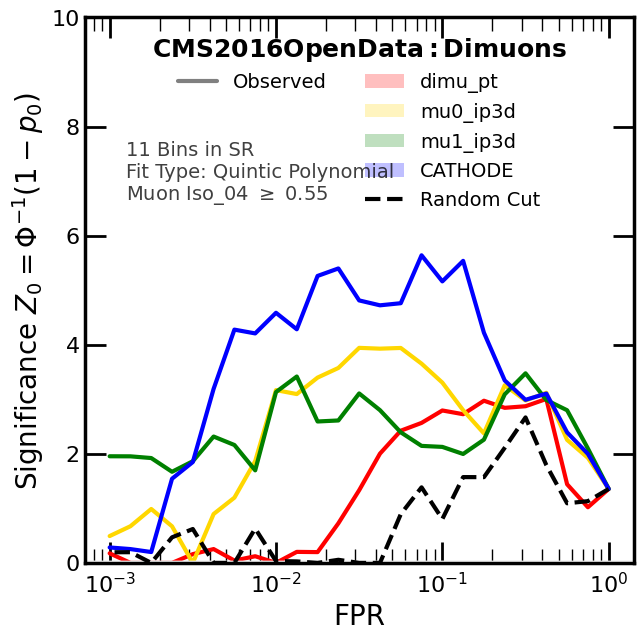

In [ ]:
def get_median_percentiles(x_array):
    
    x_median = np.nanmedian(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs[key][:,0]
    print(SIG_observed)
    # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs[key][:,1:])
    # # SIG_median = SIG_observed
    # # SIG_lower = SIG_observed
    # # SIG_upper = SIG_observed
    # # SIG_2lower = SIG_observed
    # # SIG_2upper = SIG_observed

    # print(key)
    # index = 0
    # print("max observed significance", np.max(SIG_observed))
    # print("Original Significance", SIG_observed[index])
    # print("Median significance", SIG_median[index])
    # print("+1sigma significance", SIG_lower[index], SIG_upper[index])
    # print("+2sigma significance", SIG_2lower[index], SIG_2upper[index])

    # print("Percent of 0", np.sum(feature_SIGs[key][index,1:] == 0)/len(feature_SIGs[key][index,1:]))
    

    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    # ax.plot(fpr_thresholds_finegrained, SIG_median, color = colors[i], linestyle = "dashed", alpha = 0.5)
    # ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
    # ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])

    print("max observed significance", np.max(SIG_observed))

# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")


# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")

# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)

<>:48: SyntaxWarning: invalid escape sequence '\P'
<>:48: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_725053/110416016.py:48: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 10.0)

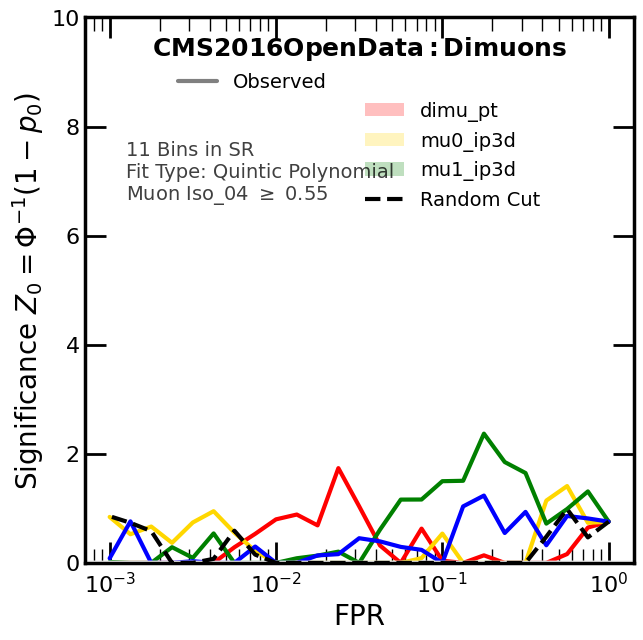

In [ ]:
# same plot but for the alternative data

fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue", "black"]

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs_alt[key][:,0]
    # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt[key][:,1:])
    # SIG_median = SIG_observed
    # SIG_lower = SIG_observed
    # SIG_upper = SIG_observed
    # SIG_2lower = SIG_observed
    # SIG_2upper = SIG_observed
    


    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    if key == "random":
        ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = colors[i], alpha = 0.5)
        # ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = colors[i])
        # ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = colors[i])


# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys())
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")

# Add the keys in a seperate column with filled color

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):

    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")

# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs_alt["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {fit_type.capitalize()} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)

plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")




